In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
import os
import csv
import numpy as np

In [2]:
data_dir='~/data/twconv/twconv_2016_usersec'
data_dir=os.path.expanduser(data_dir)
fpath = os.path.join(data_dir, 'conversations_large.csv')
ds = pd.read_csv(fpath, parse_dates=['timestamp'])
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520263 entries, 0 to 520262
Data columns (total 14 columns):
id                       520263 non-null int64
screen_name              520263 non-null object
latitude                 4063 non-null float64
longitude                4063 non-null float64
lang                     520263 non-null object
in_reply_to_status_id    507354 non-null float64
created_at               520263 non-null object
text                     520263 non-null object
timestamp                520247 non-null datetime64[ns]
conversation_id          520263 non-null int64
conversation_deep        520263 non-null int64
num_replies              520263 non-null int64
num_users                520263 non-null int64
url                      520263 non-null object
dtypes: datetime64[ns](1), float64(3), int64(5), object(5)
memory usage: 55.6+ MB


In [11]:
convdist = ds[(ds.num_replies>1) & (ds.in_reply_to_status_id.isnull())]
convdist.num_replies.head()

0     3
11    2
14    7
21    2
25    2
Name: num_replies, dtype: int64

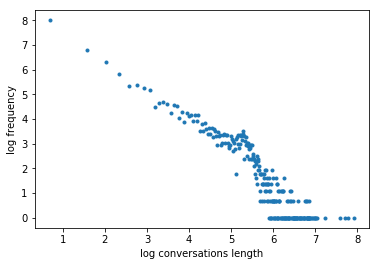

In [28]:
y, bins = np.histogram(convdist.num_replies, bins=1000)
x=bins[:-1]
ix = y!=0
y_log = np.log(y[ix])
x_log = np.log(x[ix])
plt.scatter(x_log, y_log, marker='.')
plt.xlabel('log conversations length')
plt.ylabel('log frequency')
#plt.savefig('conversations_distribution.eps', format='eps',bbox_inches='tight')

In [88]:
import powerlaw
data = convdist.num_replies.values
results = powerlaw.Fit(data, discrete=True, xmin=2)
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')
print(R,p)

1.4368275542071471
2.0
-475.16957769914654 2.598467693989193e-90


In [48]:
len(np.unique(data)), len(data>1), len(data)

(500, 8793, 8793)

In [49]:
power_law = results.power_law.pdf()
len(power_law)

8793

In [50]:
exponential = results.exponential.pdf()
len(exponential)

8793

In [79]:
bins, empirical = results.pdf(bins=500)
len(bins), len(empirical)

(501, 500)

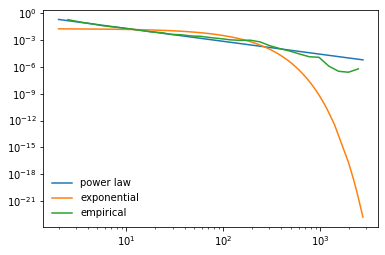

In [82]:
ax= results.power_law.plot_pdf(label='power law')
ax2=results.exponential.plot_pdf(label='exponential')
ax3=results.plot_pdf(label='empirical')
plt.legend(frameon=False)

In [73]:
len(ax.lines), ax.lines[0].get_xydata().shape,ax.lines[1].get_xydata().shape, ax.lines[2].get_xydata().shape

(3, (500, 2), (500, 2), (30, 2))

In [86]:
powerlaw = ax.lines[0].get_xydata()
exponential= ax.lines[1].get_xydata()
empirical = ax.lines[2].get_xydata()

powerlaw_ds = pd.DataFrame(powerlaw, columns=['bins', 'pdf'])
exponential_ds = pd.DataFrame(exponential, columns=['bins', 'pdf'])
empirical_ds = pd.DataFrame(empirical, columns=['bins', 'pdf'])

pd.concat([powerlaw_ds.head(), exponential_ds.head(), empirical_ds.head()], axis=1)

,bins,pdf,bins,pdf,bins,pdf
0,2.0,0.194686,2.0,0.017330,2.5,0.183669
1,3.0,0.108723,3.0,0.017029,3.5,0.091778
2,4.0,0.071913,4.0,0.016734,4.5,0.061754
3,5.0,0.052187,5.0,0.016444,5.5,0.041055
4,6.0,0.040160,6.0,0.016159,7.0,0.030081


In [87]:
powerlaw_ds.to_csv('powerlaw_dist.csv', index=False)
exponential_ds.to_csv('exponential_dist.csv', index=False)
empirical_ds.to_csv('empirical_dist.csv', index=False)

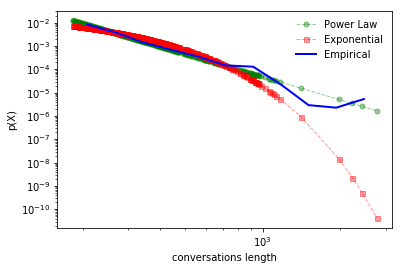

In [45]:
from powerlaw import plot_pdf, Fit, pdf
#https://pypi.org/project/powerlaw/
#http://nbviewer.jupyter.org/github/jeffalstott/powerlaw/blob/master/manuscript/Manuscript_Code.ipynb
#plot_pdf(data, color='b', linewidth=2)
#results.power_law.plot_pdf(linestyle=':', color='g')
results.power_law.plot_pdf( linestyle='--', color='g', marker='o',markersize=5, linewidth=1,alpha=0.4, label='Power Law')
results.exponential.plot_pdf(linestyle='--', color='r', marker='s',markersize=5,linewidth=1,alpha=0.4, label='Exponential')
results.plot_pdf(color='b', linewidth=2, label=r'Empirical')
plt.legend(frameon=False)
plt.xlabel('conversations length')
plt.ylabel('p(X)')
#plt.savefig('../results/conversations_distribution.eps', format='eps',bbox_inches='tight')